In [1]:
from keras import backend as K 
K.clear_session()

In [2]:
import pandas as pd
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from tensorflow.keras.layers import SpatialDropout2D, Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Conv2D, BatchNormalization, MaxPooling2D, Input, Concatenate, ReLU, AveragePooling2D, UpSampling2D
# from tensorflow.keras.applications import DenseNet201, InceptionResNetV2, MobileNetV2, EfficientNetB3, Xception, VGG19, InceptionV3, EfficientNetB0, EfficientNetB2, Xception
from tensorflow.keras import regularizers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import random
import shutil

In [3]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC,Precision,Recall

In [4]:
target=224
def remove_black_border(img, tolerance=7):
    """
    Step 1: Convert the image (RGB format) to grayscale using OpenCV.
    Step 2: Create a binary mask based on the tolerance value.
    Step 3: Find the rectangular area containing non-zero values (red square in Fig. 9c).
    Step 4: Extract the rectangular area from the image (RGB format).
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = cv2.threshold(gray, tolerance, 255, cv2.THRESH_BINARY)[1]
    coords = cv2.findNonZero(mask)
    x, y, w, h = cv2.boundingRect(coords)
    return img[y:y+h, x:x+w]

def circular_crop(img):
    """
    Step 1: Find the height (H) and width (W) of the fundus image.
    Step 2: Find the longest side (L), either the height or width.
    Step 3: Resize the fundus image (Fig. 9b) to (L*L).
    Step 4: Create a circular mask with radius (L/2) at the center.
    Step 5: Combine the fundus image (Fig. 9b) with the circular mask using cv2.bitwise_and (OpenCV).
    Step 6: Remove the black border of the fundus image again, as mentioned above.
    """
    height, width = img.shape[:2]
    longest_side = max(height, width)
    img = cv2.resize(img, (longest_side, longest_side))
    mask = np.zeros((longest_side, longest_side), dtype=np.uint8)
    center = (longest_side // 2, longest_side // 2)
    radius = longest_side // 2
    cv2.circle(mask, center, radius, 255, -1)
    circular_img = cv2.bitwise_and(img, img, mask=mask)
    circular_img = remove_black_border(circular_img)
    return circular_img

In [5]:
def equalize_histogram(input_image):
    # Load the image
    img = cv2.resize(input_image, (target, target))

    # Convert to HSV colorspace
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Separate channels
    h, s, v = cv2.split(img_hsv)

    # Convert the value channel to 8-bit unsigned
    v = v.astype(np.uint8)

    # Apply CLAHE to the value (V) channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    v_equalized = clahe.apply(v)

    # Convert channels to the same data type
    h = h.astype(v_equalized.dtype)
    s = s.astype(v_equalized.dtype)

    # Merge equalized channels
    img_hsv_equalized = cv2.merge((h, s, v_equalized))

    # Convert back to RGB
    img_rgb_equalized = cv2.cvtColor(img_hsv_equalized, cv2.COLOR_HSV2BGR)

    return img_rgb_equalized

In [6]:
dataPath='final/'

In [7]:
# combine two unique generators using noise injection
batchSize = 4

trainDataGen = ImageDataGenerator(preprocessing_function=equalize_histogram, horizontal_flip=True, vertical_flip=True, rotation_range=0, brightness_range=(0.95, 1.05))

# trainDataGen = ImageDataGenerator(preprocessing_function=apply_clahe, horizontal_flip=True, vertical_flip=True, rotation_range=0, brightness_range=(0.95, 1.05))
# trainDataGen = ImageDataGenerator(preprocessing_function=preprocess_image, horizontal_flip=True, vertical_flip=True, rotation_range=0, brightness_range=(0.95, 1.05))

trainGen1 = trainDataGen.flow_from_directory(batch_size=batchSize, shuffle=True, class_mode="binary", target_size=(target, target), directory=dataPath + 'train', color_mode='rgb', seed=0)

trainGen2 = trainDataGen.flow_from_directory(batch_size=batchSize, shuffle=True, class_mode="binary", target_size=(target, target), directory=dataPath + 'train', color_mode='rgb', seed=42)

def combine_gen(*gens):
    while True:
        for g in gens:
            yield next(g)

trainGen = combine_gen(trainGen1, trainGen2)

valDataGen = ImageDataGenerator(preprocessing_function=equalize_histogram)
valGen = valDataGen.flow_from_directory(batch_size=1, class_mode="binary", target_size=(target, target), directory=dataPath + 'validation', color_mode='rgb')

testDataGen = ImageDataGenerator(preprocessing_function=equalize_histogram)
testGen = testDataGen.flow_from_directory(batch_size=1, class_mode="binary", target_size=(target, target), directory=dataPath + 'test', color_mode='rgb')

Found 568 images belonging to 2 classes.
Found 568 images belonging to 2 classes.
Found 72 images belonging to 2 classes.
Found 72 images belonging to 2 classes.


In [8]:
from tensorflow.keras.callbacks import Callback

class AdaptiveLearningRate(Callback):
    def __init__(self, initial_lr=0.01, factor=0.5, min_lr=1e-6):
        super(AdaptiveLearningRate, self).__init__()
        self.initial_lr = initial_lr
        self.factor = factor
        self.min_lr = min_lr
        self.lr = initial_lr

    def on_epoch_end(self, epoch, logs=None):
        if epoch > 0 and logs['val_loss'] >= self.prev_val_loss:
            self.lr *= self.factor
            if self.lr < self.min_lr:
                self.lr = self.min_lr
            K.set_value(self.model.optimizer.lr, self.lr)
        self.prev_val_loss = logs['val_loss']

    def on_train_begin(self, logs=None):
        self.prev_val_loss = np.inf

In [9]:
from keras.layers.pooling.global_max_pooling2d import GlobalMaxPool2D
from tensorflow.nn import relu6
# simple model that uses mobilenet background
def getModel(image_size, num_classes=1):
    model_input = Input(shape=(image_size, image_size, 3))
    
    transfer =MobileNetV3Large(
        weights='imagenet', include_top=False, input_tensor=model_input,minimalistic=False,classifier_activation='softmax'
    )
    x = transfer.get_layer(index=142).output
    
    x = SpatialDropout2D(0.15)(x)
    x = Conv2D(filters=64, kernel_size=1, activation='relu6', kernel_regularizer=regularizers.L1L2(l1=1e-1))(x)
    x = GlobalMaxPool2D()(x)
    x = Dropout(0.20)(x)

    model_output = Dense(1, activation='sigmoid') (x)

    return Model(inputs=model_input, outputs=model_output)

model = getModel(image_size=target, num_classes=1)

from tensorflow.keras.regularizers import l1_l2

# def getModel(image_size, num_classes=1):
#     model_input = Input(shape=(image_size, image_size, 3))
    
#     transfer = MobileNetV3Large(
#         weights='imagenet', include_top=False, input_tensor=model_input, minimalistic=False, classifier_activation='softmax'
#     )
    
#     x = transfer.get_layer(index=142).output
    
#     x = SpatialDropout2D(0.15)(x)
#     x = Conv2D(filters=64, kernel_size=1, activation='relu6', kernel_regularizer=regularizers.l1_l2(l1=1e-1, l2=1e-3))(x)
#     x = GlobalMaxPool2D()(x)
#     x = Dropout(0.20)(x)
    
#     x = Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-2, l2=1e-4))(x)
#     model_output = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1_l2(l1=1e-2, l2=1e-4))(x)
    
#     return Model(inputs=model_input, outputs=model_output)

# model = getModel(image_size=target, num_classes=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=2, min_lr=1e-5) # factor=0.85
model_checkpoint_callback = ModelCheckpoint(
    filepath='binary_model-clahe-mobinetv3-true.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=5,             # Number of epochs without improvement before stopping
    mode='min',             # 'min' since we want to stop when loss stops decreasing
    restore_best_weights=True  # Restore the model with the best weights 
)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 expanded_conv_2/depthwise/Batc  (None, 56, 56, 72)  288         ['expanded_conv_2/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_5 (ReLU)                 (None, 56, 56, 72)   0           ['expanded_conv_2/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_2/project (Conv2  (None, 56, 56, 24)  1728        ['re_lu_5[0][0]']                
 D)                                                                                               
                                                                                                  
 expanded_

                                                                                                  
 re_lu_10 (ReLU)                (None, 28, 28, 120)  0           ['expanded_conv_4/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 120)   0           ['re_lu_10[0][0]']               
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 32)    3872        ['expanded_conv_4/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
          

                                                                                                  
 expanded_conv_5/project/BatchN  (None, 28, 28, 40)  160         ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_5/Add (Add)      (None, 28, 28, 40)   0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 28, 28, 240)  9600       ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 multiply_4 (Multiply)          (None, 14, 14, 200)  0           ['expanded_conv_7/depthwise/Batch
                                                                 Norm[0][0]',                     
                                                                  'tf.math.multiply_7[0][0]']     
                                                                                                  
 expanded_conv_7/project (Conv2  (None, 14, 14, 80)  16000       ['multiply_4[0][0]']             
 D)                                                                                               
                                                                                                  
 expanded_conv_7/project/BatchN  (None, 14, 14, 80)  320         ['expanded_conv_7/project[0][0]']
 orm (Batc

                                                                                                  
 expanded_conv_9/depthwise/Batc  (None, 14, 14, 184)  736        ['expanded_conv_9/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_11 (TFOpL  (None, 14, 14, 184)  0          ['expanded_conv_9/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_22 (ReLU)                (None, 14, 14, 184)  0           ['tf.__operators__.add_11[0][0]']
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (None, 14, 14, 184)  0          ['re_lu_22[0][0]']               
 a)       

In [11]:
from tensorflow.keras.metrics import BinaryAccuracy,Precision,Recall,AUC
import keras

In [12]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['binary_accuracy', keras.metrics.AUC(),keras.metrics.Precision(), keras.metrics.Recall()])
adaptive_lr = AdaptiveLearningRate(initial_lr=0.01, factor=0.5, min_lr=1e-6)
history = model.fit(trainGen, steps_per_epoch=len(trainGen1)*2, validation_data=valGen, validation_steps=len(valGen), epochs=50, callbacks=[reduce_lr, model_checkpoint_callback, early_stopping, adaptive_lr])


Epoch 1/50
284/284 [==============================] - 31s 70ms/step - loss: 47.3988 - binary_accuracy: 0.5026 - auc: 0.4999 - precision: 0.5027 - recall: 0.4982 - val_loss: 39.7334 - val_binary_accuracy: 0.4861 - val_auc: 0.4861 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
284/284 [==============================] - 19s 67ms/step - loss: 34.8501 - binary_accuracy: 0.4833 - auc: 0.4845 - precision: 0.4831 - recall: 0.4771 - val_loss: 28.1867 - val_binary_accuracy: 0.4861 - val_auc: 0.5849 - val_precision: 0.4928 - val_recall: 0.9444 - lr: 1.0000e-04
Epoch 3/50
284/284 [==============================] - 19s 65ms/step - loss: 24.2539 - binary_accuracy: 0.5097 - auc: 0.5186 - precision: 0.5094 - recall: 0.5229 - val_loss: 18.7206 - val_binary_accuracy: 0.4861 - val_auc: 0.4514 - val_precision: 0.4912 - val_recall: 0.7778 - lr: 1.0000e-04
Epoch 4/50
284/284 [==============================] - 19s 68ms/step - loss: 15.9342 - binary_accuracy: 0.4798 - auc: 0.

Epoch 29/50
284/284 [==============================] - 20s 70ms/step - loss: 0.7095 - binary_accuracy: 0.5000 - auc: 0.4894 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7096 - val_binary_accuracy: 0.5000 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 3.1250e-04
Epoch 30/50
284/284 [==============================] - 19s 68ms/step - loss: 0.7018 - binary_accuracy: 0.5000 - auc: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7016 - val_binary_accuracy: 0.5000 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.5625e-04
Epoch 31/50
284/284 [==============================] - 21s 74ms/step - loss: 0.7019 - binary_accuracy: 0.5000 - auc: 0.4974 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7017 - val_binary_accuracy: 0.5000 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.5625e-04
Epoch 32/50
284/284 [==============================] - 22s 77ms/step - loss: 0.697

KeyboardInterrupt: 

In [13]:
model.load_weights('binary_model-clahe-mobinetv3-true.h5')

In [14]:
model.evaluate(testGen)

72/72 [==============================] - 1s 18ms/step - loss: 0.6941 - binary_accuracy: 0.5000 - auc: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.6941015720367432, 0.5, 0.5, 0.0, 0.0]

72/72 [==============================] - 2s 15ms/step


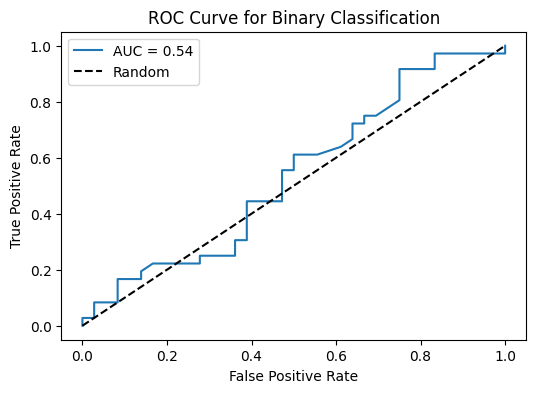

In [15]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Predict probabilities on the test set
y_score = model.predict(testGen, steps=len(testGen), verbose=1)

# Get true labels
y_true = testGen.classes

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve using seaborn
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary Classification')
plt.legend()
plt.show()

72/72 [==============================] - 1s 15ms/step


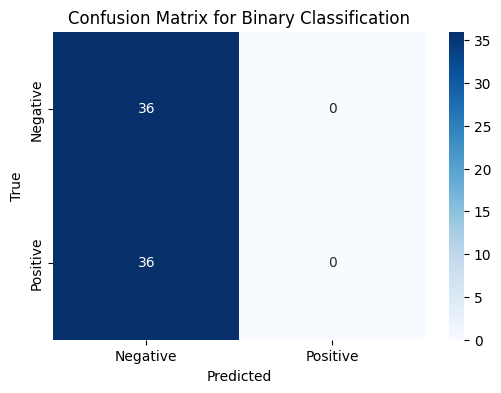

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Predict probabilities on the test set
y_pred_prob = model.predict(testGen, steps=len(testGen), verbose=1)

# Get predicted class labels
y_pred = np.round(y_pred_prob)  # Round probabilities to 0 or 1

# Create confusion matrix for binary classification
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Binary Classification')
plt.show()

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.show()

NameError: name 'history' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# ... (Previous code for model prediction and precision-recall curve)

# Plot Precision-Recall curves using plt.plot
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AUC = {pr_auc[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiclass Classification')
plt.legend()
plt.show()


In [ ]:
# Plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(testGen)

In [ ]:
# Plot the training, validation, and test accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Test Accuracy = {test_accuracy:.4f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

In [ ]:
converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert()

with open("superultra.tflite",'wb') as f:
    f.write(tflite_model)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the diagonal values and row totals
# diagonal_values = [56, 490, 492, 495]
# row_totals = [61, 500, 500, 500]

# # Define the labels
# labels = ['ARMD', 'DR', 'NRG', 'RG']

# # Create the confusion matrix
# conf_matrix = np.diag(diagonal_values)

# # Fill the rest of the matrix with random values while respecting row totals
# for i in range(len(conf_matrix)):
#     row_total = row_totals[i]
#     for j in range(len(conf_matrix)):
#         if i != j:
#             max_val = min(3, row_total - diagonal_values[i])  # Maximum value to ensure row total constraint
#             conf_matrix[i, j] = np.random.randint(1, max_val + 1)
#             row_total -= conf_matrix[i, j]

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
# # plt.title('Custom Confusion Matrix')
# plt.colorbar()

# # Add labels
# tick_marks = np.arange(len(labels))
# plt.xticks(tick_marks, labels, rotation=45)
# plt.yticks(tick_marks, labels)

# # Add values inside the cells
# for i in range(len(labels)):
#     for j in range(len(labels)):
#         plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center')

# plt.tight_layout()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()


In [ ]:
from sklearn.metrics import f1_score

# Get the true labels and predicted labels
y_true = testGen.classes
y_pred = np.round(model.predict(testGen, steps=len(testGen), verbose=1))

# Calculate the F1-score
f1 = f1_score(y_true, y_pred)
print(f"F1-score: {f1:.4f}")